# Preliminary Data Analysis

This notebook conducts the preliminary analysis on the following data sets;

- consumer_fraud_probability.csv
- consumer_user_details.parquert
- merchant_fraud_probability.csv
- tbl_consumer.csv
- tbl_merchants.parquet

A breakdown of each of the attributes is conducted, as well as relevant visualisations. .<br>
NULL and invalid data entires are also tested for in each data set.


In [223]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F
from collections import Counter

In [9]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("prelim data analysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

### Checker Functions Used

In [56]:
def df_null_checker(df):
	"""
	This function returns the number of null values 
	in a dataframe, both per attribute and in total
	"""

	null_values_per_col = df.isnull().sum()
	total_null = null_values_per_col.sum()

	print(f"NULL values per coloumn: \n{null_values_per_col}")
	print(f"\nTotal NULL values in dataframe is: {total_null}")
	
	return 

In [232]:
def date_time_checker(col):
	"""
	This function tests if the dates provided are correct and valid. 
	If they are any invalid dates it will return an error.
	Otherwise it will run through and print that there was no errors.
	"""
	for entry in col:
		year = int(entry[0:4])
		month = int(entry[5:7])
		day = int(entry[8:10])

		datetime.datetime(year=year,month=month,day=day)
	print("No Invalid Dates Detected")
	return


### consumer_fraud_probability.csv

In [182]:
# 'consumer_fraud_probability.csv' file
path = '../../../data/raw/tables/consumer_fraud_probability.csv'
cust_fp = pd.read_csv(path)

print(cust_fp.head())
print(cust_fp.dtypes)

   user_id order_datetime  fraud_probability
0     6228     2021-12-19          97.629808
1    21419     2021-12-10          99.247380
2     5606     2021-10-17          84.058250
3     3101     2021-04-17          91.421921
4    22239     2021-10-19          94.703425
user_id                int64
order_datetime        object
fraud_probability    float64
dtype: object


In [233]:
# checking for NULL values
df_null_checker(cust_fp)

# checking order_datetime 
date_time_checker(cust_fp['order_datetime'])

NULL values per coloumn: 
user_id              0
order_datetime       0
fraud_probability    0
dtype: int64

Total NULL values in dataframe is: 0
No Invalid Dates Detected


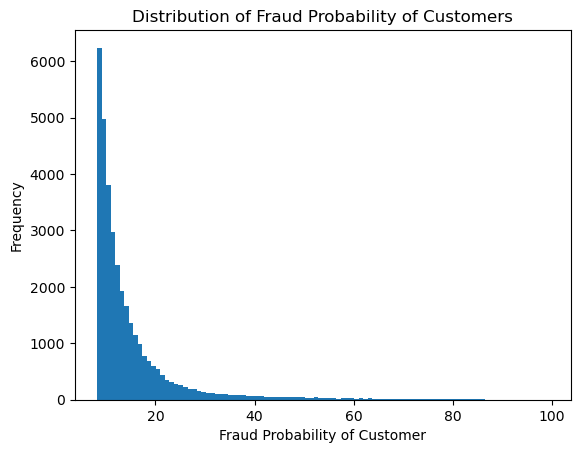

In [4]:
data = cust_fp['fraud_probability']

plt.hist(data, bins=100)

plt.xlabel('Fraud Probability of Customer')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Probability of Customers')

# Show the plot
plt.show()

We can observe from the above graph, there are no values that are between 0 and 100, hence showing they are all valid.

### consumer_user_details.parquet

In [60]:
path = '../data/tables/consumer_user_details.parquet'
cust_user_det = spark.read.parquet(path)

print(cust_user_det.limit(10))
print(cust_user_det.printSchema())

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
|      6|     407340|
|      7|     511685|
|      8|     448088|
|      9|     650435|
|     10|    1058499|
+-------+-----------+

root
 |-- user_id: long (nullable = true)
 |-- consumer_id: long (nullable = true)

None


In [66]:
# checking for NULL values
# first have to convert to a pandas df to pass through the function
cust_user_det_df = cust_user_det.toPandas()
df_null_checker(cust_user_det_df)

NULL values per coloumn: 
user_id        0
consumer_id    0
dtype: int64

Total NULL values in dataframe is: 0


### merchant_fraud_probability.csv

In [222]:
# 'merchant_fraud_probability.csv' file
path = '../../../data/raw/tables/merchant_fraud_probability.csv'
merch_fp = pd.read_csv(path)

print(merch_fp.head())
print(merch_fp.dtypes)

   merchant_abn order_datetime  fraud_probability
0   19492220327     2021-11-28          44.403659
1   31334588839     2021-10-02          42.755301
2   19492220327     2021-12-22          38.867790
3   82999039227     2021-12-19          94.134700
4   90918180829     2021-09-02          43.325517
merchant_abn           int64
order_datetime        object
fraud_probability    float64
dtype: object


In [235]:
# checking for NULL values
df_null_checker(merch_fp)

# checking valid date times
date_time_checker(merch_fp['order_datetime'])

NULL values per coloumn: 
merchant_abn         0
order_datetime       0
fraud_probability    0
dtype: int64

Total NULL values in dataframe is: 0
No Invalid Dates Detected


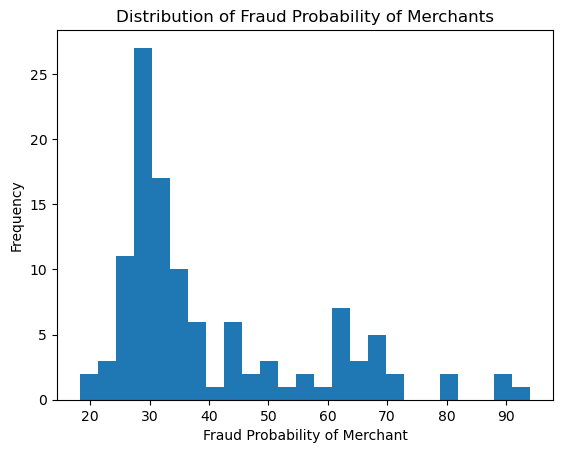

In [236]:
data = merch_fp['fraud_probability']

plt.hist(data, bins=25)

plt.xlabel('Fraud Probability of Merchant')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Probability of Merchants')

# Show the plot
plt.show()

We can observe from the above graph, there are no values that are between 0 and 100, hence showing they are all valid.

### tbl_consumer.csv

In [237]:
path = '../../../data/raw/tables/tbl_consumer.csv'
tbl_cust = pd.read_csv(path, delimiter='|')

print(tbl_cust.head())
print(tbl_cust.dtypes)


                name                        address state  postcode  gender  \
0   Yolanda Williams     413 Haney Gardens Apt. 742    WA      6935  Female   
1         Mary Smith                3764 Amber Oval   NSW      2782  Female   
2      Jill Jones MD             40693 Henry Greens    NT       862  Female   
3    Lindsay Jimenez      00653 Davenport Crossroad   NSW      2780  Female   
4  Rebecca Blanchard  9271 Michael Manors Suite 651    WA      6355  Female   

   consumer_id  
0      1195503  
1       179208  
2      1194530  
3       154128  
4       712975  
name           object
address        object
state          object
postcode        int64
gender         object
consumer_id     int64
dtype: object


Although 3 digit postcodes are legitimate, in the ABS data they might be recorded down as 0XXX, so a 0 should be added to the front of the postcode

In [70]:
# checking for NULL values
df_null_checker(tbl_cust)

NULL values per coloumn: 
name           0
address        0
state          0
postcode       0
gender         0
consumer_id    0
dtype: int64

Total NULL values in dataframe is: 0


In [238]:
# checking how many postcodes are 3 digits.
# although these might be 'correct' we still want to add a '0' to the front 
# of them, so we can eaily compare them to the SA2 zones data
postcode_list = pd.Series(tbl_cust['postcode'])
unique_pc = Counter(postcode_list)

three_digit_count = 0
for value in unique_pc:
    if len(str(value))==3 :
        three_digit_count += 1

print('Number of 3 Digit Postcodes:', three_digit_count)   

Number of 3 Digit Postcodes: 50


In [239]:
# ensuring there are no double ups within the consumer_id col
id_count = pd.Series(tbl_cust['consumer_id']).value_counts()
for value in id_count:
    if value != 1:
        print("Duplicate entry:", value)
    if value == None:
        print('Null Value')

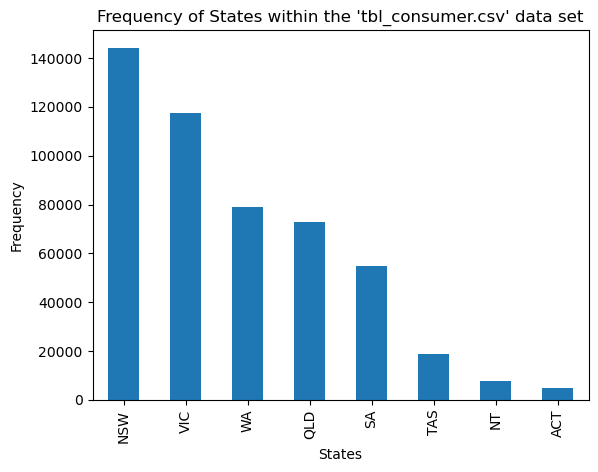

In [241]:
# plots showing the frequency of the State and Gender values in 'tbl_consumer.csv' dataset
state_count = pd.Series(tbl_cust['state']).value_counts()
state_count.plot(title='Frequency of States within the \'tbl_consumer.csv\' data set', xlabel='States', ylabel='Frequency', kind='bar')
plt.show()

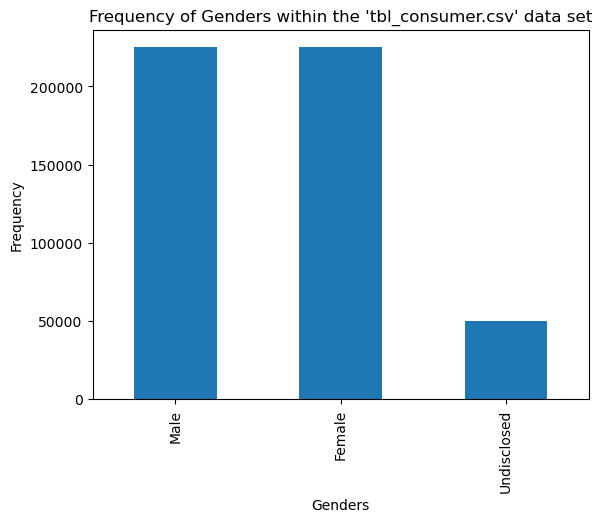

In [242]:
gender_count = pd.Series(tbl_cust['gender']).value_counts()
gender_count.plot(title='Frequency of Genders within the \'tbl_consumer.csv\' data set', xlabel='Genders', ylabel='Frequency', kind='bar')
plt.show()

### tbl_merchants.parquet

In [72]:
path = '../../../data/raw/tables/tbl_merchants.parquet'
tbl_merch = spark.read.parquet(path)

print(tbl_merch.limit(10))
print(tbl_merch.printSchema())

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
|       Fusce Company|[(gift, card, nov...| 10206519221|
|Aliquam Enim Inco...|[(computers, comP...| 10255988167|
|    Ipsum Primis Ltd|[[watch, clock, a...| 10264435225|
|Pede Ultrices Ind...|([computer progra...| 10279061213|
|           Nunc Inc.|[(furniture, home...| 10323485998|
+--------------------+--------------------+------------+

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)

None


In [73]:
# first have to convert to a pandas df to pass through the function
tbl_merch_df = tbl_merch.toPandas()
df_null_checker(tbl_merch_df)

NULL values per coloumn: 
name            0
tags            0
merchant_abn    0
dtype: int64

Total NULL values in dataframe is: 0


In [243]:
tags = tbl_merch.select('tags')

print("Examples of each different format of entry in the tags coloumn:")
print(tags.collect()[0])
print(tags.collect()[1])
print(tags.collect()[5])
print(tags.collect()[7])

Examples of each different format of entry in the tags coloumn:
Row(tags='((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))')
Row(tags='([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])')
Row(tags='[(gift, card, novelty, and souvenir shops), (a), (take rate: 6.34)]')
Row(tags='[[watch, clock, and jewelry repair shops], [c], [take rate: 2.39]]')


In [245]:
for entry in tags.collect():
	input_string = entry[0]
	print(entry[0])

((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))
([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])
([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])
([wAtch, clock, and jewelry repair shops], [b], [take rate: 3.29])
([music shops - musical instruments, pianos, and sheet music], [a], [take rate: 6.33])
[(gift, card, novelty, and souvenir shops), (a), (take rate: 6.34)]
[(computers, comPUter peripheral equipment, and softwAre), (b), (take rate: 4.32)]
[[watch, clock, and jewelry repair shops], [c], [take rate: 2.39]]
([computer programming , data processing, and integrated systems design services], [a], [take rate: 5.71])
[(furniture, home furnishings and equipment shopS, and manufacturers, except appliances), (a), (take rate: 6.61)]
([computers, computer peripheral equipment, and software], [a], [take rate: 6.34])
((equipment, tool, furniture, and appliance  ren